In [1]:
import time, os

# Numpy
import numpy as np
import scipy
import sklearn
import pandas as pd

# Tensorflow and keras layers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense,\
                                    Activation, ZeroPadding2D,\
                                    BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D,\
                                    Dropout, GlobalMaxPooling2D,\
                                    GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import activations
from tensorflow.keras import backend
from tensorflow.keras import layers

# To generate GIFs


import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL

from datetime import datetime

from tqdm.auto import tqdm

import IPython
from IPython import display
import ipywidgets as widgets

import ngraph_bridge
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.python.tools import freeze_graph
import json

from numpy.random import seed
from tensorflow import set_random_seed

def reset_seed():
    # Making results reproducible
    seed(10092)
    set_random_seed(10093)  

import urllib
import xml
import re

/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it wi

In [2]:
# Retrieve list of categories.

def list_bucket(regexp='.*'):
    """Returns a filtered list of Keys in specified GCS bucket."""
    keys = []
    fh = urllib.request.urlopen('https://storage.googleapis.com/quickdraw_dataset/')
    content = xml.dom.minidom.parseString(fh.read())
    for e in content.getElementsByTagName('Contents'):
        key = e.getElementsByTagName('Key')[0].firstChild.data
        if re.match(regexp, key):
            keys.append(key)
    return [x[len(x) - x[::-1].find('/'):-4] for x in keys]


def retrieve(key, filename):
    url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/%s.npy' % (urllib.parse.quote(key))
    print('URL: %s' % (url))
    open(filename, 'wb').write(urllib.request.urlopen(url).read())


def download_dataset():
    keys = list_bucket( '.*npy$')
    for key in keys:
        retrieve(key, 'dataset/' + key + '.npy')


# Auxiliary Code

In [3]:
def create_dir(dirname):
    try:
        # Create target Directory
        os.mkdir(dirname)
        #print("dirname " , filename ,  " Created ") 
    except FileExistsError:
        print("Directory " , dirname ,  " already exists")

create_dir('models')

def create_dataset(key = 'apple'):
    main_dataset = np.load('dataset/%s.npy' % (key))
    main_dataset_len = len(main_dataset)
    files = [x for x in glob.glob('dataset/*.npy') if not key in x] 
    num_files = len(files)
    elems_per_file = int(np.ceil(main_dataset_len / num_files))
    print("Main dataset has %d elements. Taking %d per dataset for a total of %d datasets" % (main_dataset_len, 
                                                                                              elems_per_file, 
                                                                                              num_files ))
    
    for file in tqdm(files):
        #print("File:", file)
        d = np.load(file)[:elems_per_file]
        main_dataset = np.concatenate([main_dataset, d])
        #print(main_dataset.shape)
    labels = np.concatenate([np.ones(main_dataset_len), np.zeros(num_files * elems_per_file)])
    T = np.concatenate([main_dataset.T, labels.reshape(1, -1)]).T
    np.save("apple_disc.npy", T)
    
def preprocess_real_samples(samples):
    samples = samples.astype('float32').reshape(-1, 28, 28, 1)
    samples = (samples - samples.min()) / (samples.max() - samples.min())
    return samples

def load_dataset():
    T = np.load('apple_disc.npy')
    np.random.shuffle(T)
    X = T[:, :-1]
    X = X.reshape(-1, 28, 28, 1)
    Y = T[:, -1]
    print(X.shape, Y.shape)
    X = preprocess_real_samples(X)
    return X, Y

def plot_4_by_4_images(x, save = False, savefile="img.png"):
    w=10
    h=10
    fig=plt.figure(figsize=(w, h))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = np.random.randint(x.shape[0])
        fig.add_subplot(rows, columns, i)
        plt.imshow(x[i - 1, :, :, 0], cmap='gray')
    if save:
        plt.savefig(savefile)
    plt.show()
    plt.close()


def plot_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()
    plt.close()

def gen_csv(data_list, filename):
    pd.DataFrame(data_list, 
                 columns =['Epoch', 'Time (s)']).to_csv ('models/%s/times.csv'%(filename), index = False, header=True)
    

def plot_vs(x, ys, errors, title):
    fig=plt.figure(figsize=(10, 8))
    Y = ys[0]
    for y in ys:
        plt.plot(X, y[0], label=y[1])

    for y in ys[1:]:
        plt.plot(X, np.abs(Y[0] - y[0]), label='Error %s vs %s' % (Y[1], y[1]), color='crimson')
    plt.xlabel(title)
    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    plt.close()
    
def showplots(f,approxlist,a,b, names=None):
    names = ["Original"] + ["Approx. %d" % (i) for i in range(len(approxlist))] if names is None else names
    
    x = np.linspace(a,b,1000)
    plt.figure(1, figsize=(10, 8))
    plt.subplot(211)
    
    vfuncs = [np.vectorize(approx) for approx in approxlist]
    for i, vf in enumerate(vfuncs):
        plt.plot(x,vf(x), label=names[i + 1])
    plt.plot(x,f(x), label=names[0])
    plt.xlim(a,b)
    plt.ylabel('f(x) and approximations fa(x)')

    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    plt.subplot(212)
    for i, vf in enumerate(vfuncs):
        plt.plot(x,f(x)-vf(x), label=names[i + 1] + " Error")
    plt.xlim(a,b)
    plt.ylabel('error = f(x)-fa(x)')
    plt.xlabel('x')
    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    plt.show()
    plt.close()
    
def get_elapsed_time(tic):
    elapsed = time.time() - tic
    mins, secs = int(elapsed / 60), elapsed % 60
    hours, mins = int(mins / 60), mins % 60
    return "[%d HOURS, %02d MINS, %02d SECS]" % (hours, mins, secs)


Directory  models  already exists


# Code for Intel nGraph HE Transformer

In [4]:
def print_nodes(graph_def=None):
    """Prints the node names of a graph_def.
        If graph_def is not provided, use default graph_def"""

    if graph_def is None:
        nodes = [n.name for n in tf.get_default_graph().as_graph_def().node]
    else:
        nodes = [n.name for n in graph_def.node]

    print("nodes", nodes)

# https://www.dlology.com/blog/how-to-convert-trained-keras-model-to-tensorflow-and-make-prediction/
def freeze_session(session,
                   keep_var_names=None,
                   output_names=None,
                   clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import (
        convert_variables_to_constants,
        remove_training_nodes,
    )

    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(
            set(v.op.name for v in tf.global_variables()).difference(
                keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        #print_nodes(input_graph_def)
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        frozen_graph = remove_training_nodes(frozen_graph)
        return frozen_graph

def save_model(sess, output_names, directory, filename):
    frozen_graph = freeze_session(sess, output_names=output_names)
    #print_nodes(frozen_graph)
    tf.io.write_graph(frozen_graph, directory, filename + ".pb", as_text=False)
    print("Model saved to: %s" % filename + ".pb")

    
def load_pb_file(filename):
    """"Returns the graph_def from a saved protobuf file"""
    if not os.path.isfile(filename):
        raise Exception("File, " + filename + " does not exist")

    with tf.io.gfile.GFile(filename, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())

    print("Model restored")
    return graph_def

In [5]:
def get_N(total_coefficient_modulus_bit_width, security_level, sec_type='classical'):
    sec = {
        'classical':{
            128:{
                1024:  27,
                2048:  54,
                4096:  109,
                8192:  218,
                16384: 438,
                32768: 881
            },
            192:{
                1024:  19,
                2048:  37,
                4096:  75,
                8192:  152,
                16384: 305,
                32768: 611
            },
            256:{
                1024:  14,
                2048:  29,
                4096:  58,
                8192:  118,
                16384: 237,
                32768: 476
            }
        },
        'quantum':{
           128:{
                1024:  25,
                2048:  51,
                4096:  101,
                8192:  202,
                16384: 411,
                32768: 827
            },
            192:{
                1024:  17,
                2048:  35,
                4096:  70,
                8192:  141,
                16384: 284,
                32768: 571
            },
            256:{
                1024:  13,
                2048:  27,
                4096:  54,
                8192:  109,
                16384: 220,
                32768: 443
            }
        }
    }
    log2q_prev = 0
    for n, log2q in sec[sec_type][security_level].items():
        if log2q_prev < total_coefficient_modulus_bit_width < log2q:
            return n
        log2q_prev = log2q
    return n

def define_encryption_params(security_level, L):
    # Select the security level
    # Compute the multiplicative depth of the computational graph
    #L = 8 # Assumed from configuration
    # Estimate the bit-precission s, required. According to Intel, the best tradeoff is ~24 bits
    s = 24
    # Choose the coeff_modulus = [s, s, s, ..., s]. A list of L coefficient moduli, each with s bits. Set the scale to s.
    coeff_modulus = [s] * L
    coeff_modulus[0] = 30
    coeff_modulus[-1] = 30
    scale = s
    # Compute the total coefficient modulus bit width, L * s in the above parameter selection.
    total_coefficient_modulus_bit_width = L * s
    # Set the poly_modulus_degree to the smallest power of two, with coefficient modulus smaller than the maximum allowed.
    # Based on the table of recommended parameters. 
    N = get_N(total_coefficient_modulus_bit_width, security_level)
    poly_modulus_degree = N
    # For best performance, we should choose the batch_size to max_batch_size
    max_batch_size = poly_modulus_degree / 2
    # We should only include the complex packing if there are polynomial activations.
    # That is, if we make use of our own activation functions
    complex_packing = False
    
    enc_params = {
        'scheme_name': 'HE_SEAL',          # Fixed, to use the HE backend
        'poly_modulus_degree': poly_modulus_degree,       # A power of 2 {1024, 2048, 4096, 8192, 16384}
        'security_level': security_level,             # The security we want to ensure {0, 128, 192, 256}
        'coeff_modulus': coeff_modulus, # A number inbetween 1 and 60
        'scale': 2 ** s,                  # The fixed bit precission of the encoding. (log2(scale) is the number of bits)
        'complex_packing': complex_packing,
    }
    print(enc_params)
    return enc_params


def gen_json_params_file(filename, security_level=128, L=8):
    enc_params_dict = define_encryption_params(security_level, L)
    enc_params_json = json.dumps(enc_params_dict)
    with open(filename, 'w+') as file:
        file.write(enc_params_json)
    print("Generated configuration in %s" %(filename))
    

"""python test.py --batch_size=100 \
               --backend=HE_SEAL \
               --model_file=models/cryptonets.pb \
               --encrypt_server_data=true \
               --encryption_parameters=$HE_TRANSFORMER/configs/he_seal_ckks_config_N13_L8.json
"""
def get_config_for_ngraph_server(tensor_param_name):
    rewriter_options = rewriter_config_pb2.RewriterConfig()
    rewriter_options.meta_optimizer_iterations = rewriter_config_pb2.RewriterConfig.ONE
    rewriter_options.min_graph_nodes = -1
    server_config = rewriter_options.custom_optimizers.add()
    server_config.name = "ngraph-optimizer"
    server_config.parameter_map["ngraph_backend"].s = b'HE_SEAL'
    server_config.parameter_map["device_id"].s = b""
    server_config.parameter_map["encryption_parameters"].s = b'config.json'
    server_config.parameter_map["enable_client"].s = b'false'
    # Only server
    server_config.parameter_map[tensor_param_name].s = b"encrypt"
    # With client
    #server_config.parameter_map[tensor_param_name].s = b"client_input"
    # Pack data
    server_config.parameter_map[tensor_param_name].s += b",packed"

    config = tf.compat.v1.ConfigProto()
    config.MergeFrom(
            tf.compat.v1.ConfigProto(
                graph_options=tf.compat.v1.GraphOptions(
                    rewrite_options=rewriter_options)))
    return config

gen_json_params_file('config.json', security_level=128, L=4)

{'scheme_name': 'HE_SEAL', 'poly_modulus_degree': 4096, 'security_level': 128, 'coeff_modulus': [30, 24, 24, 30], 'scale': 16777216, 'complex_packing': False}
Generated configuration in config.json


## Chebyshev Polynomials Approximator Class
The class below is an implementation that allows to approximate any given function $f(x)$ in a specific interval $[a, b]$.
First we should call the function $\texttt{fit}$ and then the internal weights would be ready to execute the approximation with $\texttt{predict}$.

In [6]:
class ChebyshevPolynomial(object):
    def __init__(self):
        pass
    
    def __name__(self):
        return "ChebyshevPolynomial"
    
    def to_x(self, u, a, b):
        return ((b - a)/2) * u + ((a + b)/2)

    def to_u(self,x, a, b):
        return np.array((2 * x - a - b) / (b - a))
    
    def chebyshev_t(self, x, degree):
        if degree == 0:
            return np.ones(x.shape)
        elif degree == 1:
            return x
        else:
            return 2 * x * self.chebyshev_t(x, degree-1) - self.chebyshev_t(x, degree - 2)
        
    def chebyshev_nodes(self, N):
        t = (np.array(range(0, N)) + 0.5) / N
        return -np.cos(t * np.math.pi)
    
    def chebyshev_a(self, k):
        return 1 if k == 0 else 2
    
    def calculate_c(self, y, u, n, N):
        return self.chebyshev_a(n) * (y.dot(self.chebyshev_t(u, n))) / N

    def chebyshev_c(self, f, N, a, b):
        c = []
        u = self.chebyshev_nodes(N)
        x = self.to_x(u, a, b)
        y = f(x)
        for i in range(N):
            c.append(self.calculate_c(y, u, i, N))
        return np.round(c, 4)

    def fit(self, f, N, a, b):
        self.a = a
        self.b = b
        self.N = N
        self.C = self.chebyshev_c(f, N, a, b)
        return self 
    
    def __call__(self, x):
        return self.predict(x)
    
    def predict(self, x):
        if self.C is None:
            raise Exception
        
        u = self.to_u(x, self.a, self.b)
        y = np.zeros(u.shape)
        for degree, c in enumerate(self.C):
            ch = self.chebyshev_t(u, degree)
            y += c * ch
        
        return y

(289468, 28, 28, 1) (289468,)


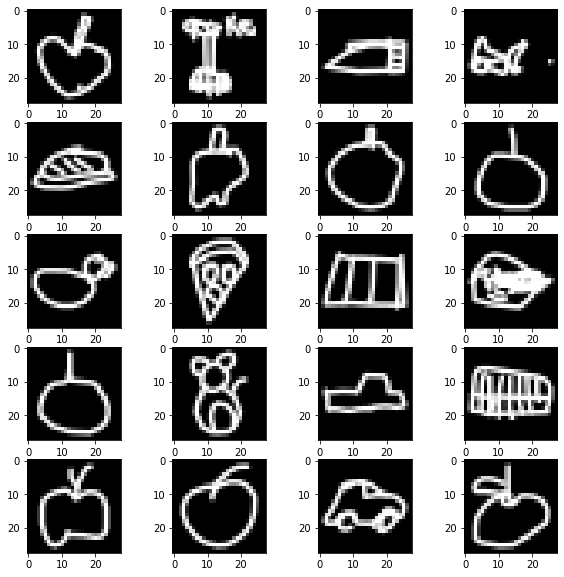

In [7]:
plot_4_by_4_images(load_dataset()[0])

# Activation Functions Approximations

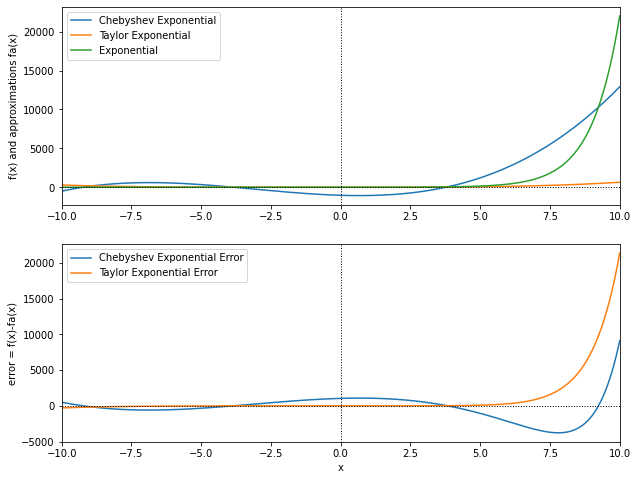

In [8]:
def taylor_exp(x, n=5):
    result = 1
    for i in range(1, n):
        result += ((x ** i) / (np.math.factorial(i)))
    return result 

def exp(x):
    e = 2.718281828459045
    return e ** x

r = 10
chebyshev_exp = ChebyshevPolynomial().fit(np.exp, 4, -r, r)
showplots(np.exp, [chebyshev_exp, taylor_exp], -r,  r , 
          names=['Exponential', 'Chebyshev Exponential', 'Taylor Exponential'])

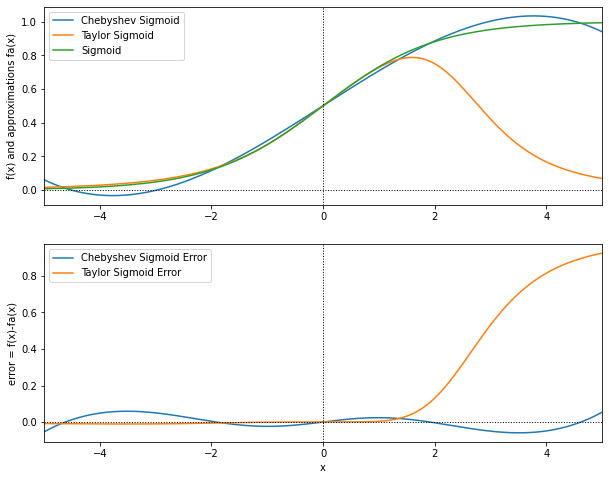

In [9]:
def taylor_sigmoid(x, n=5):
    return 1 / (1 + taylor_exp(-x, n))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def normalize_in_range(x, range_start, range_end, new_range_start= -1, new_range_end=1):
    zero_to_one = ((x - range_start) / (range_end - range_start))
    start_to_end = zero_to_one * (new_range_end - new_range_start) + new_range_start
    return start_to_end

def denormalize_in_range(x, range_start, range_end, new_range_start = -1, new_range_end=1):
    zero_to_one = ((x - new_range_start) / (new_range_end - new_range_start))
    start_to_end = zero_to_one * (range_end - range_start) + range_start
    return start_to_end
def taylor_sigmoid_norm(x, n=5, r=5):
    x = normalize_in_range(x, -r, r)
    return denormalize_in_range(taylor_sigmoid(x, n), -r, r)

r = 5
chebyshev_sigmoid = ChebyshevPolynomial().fit(sigmoid, 4, -r, r)
showplots(sigmoid, [chebyshev_sigmoid, taylor_sigmoid], -r ,  r, 
          names=['Sigmoid', 'Chebyshev Sigmoid', 'Taylor Sigmoid'])


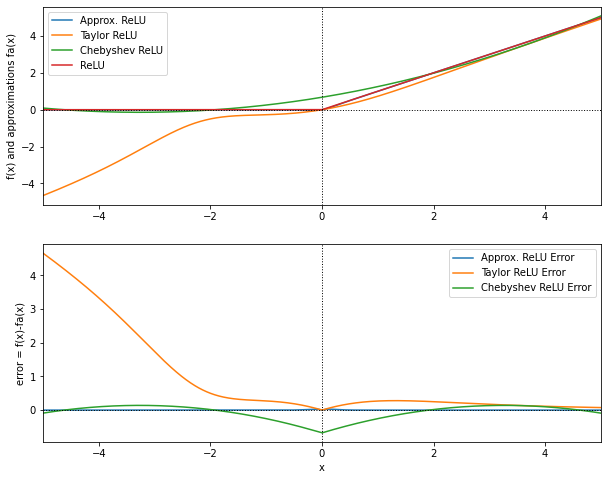

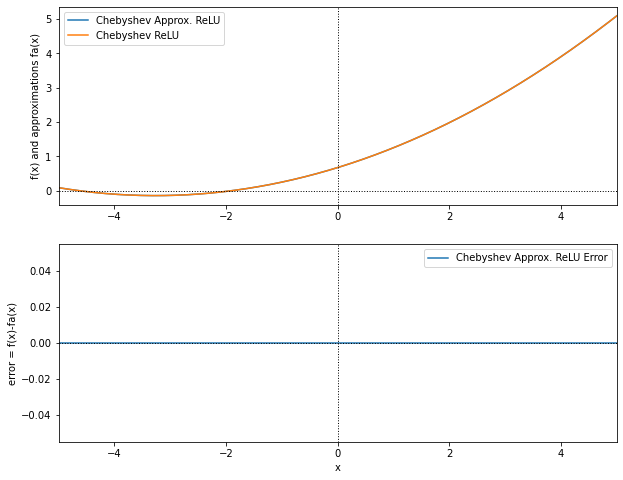

In [10]:
# Base relu implementation
def relu(x):
    return np.maximum(0, x)

# This approximation of the max function works as intended.
def approxmax(x, y, k=10):
    ekx = np.exp(k * x)
    eky = np.exp(k * y)
    return (x * ekx + y * eky) / (ekx + eky)

def approx_relu(x):
    return approxmax(x, 0)

# This is the same approximation using the Taylor Exponential
def taylor_max(x,y,k=1, degree=5):
    ekx = taylor_exp(k * x, degree)
    eky = taylor_exp(k * y, degree)
    return (x * ekx + y * eky) / (ekx + eky)

def taylor_relu(x):
    return taylor_max(0, x)

# This is the same approximation using the Chebyshev Exponential.
def chebyshev_max(x, y, k=10):
    ekx = chebyshev_exp(k * x)
    eky = chebyshev_exp(k * y)
    return (x * ekx + y * eky) / (ekx + eky)

def chebyshev_relu_max(x):
    return chebyshev_max(0, x)




r = 5
chebyshev_relu = ChebyshevPolynomial().fit(relu, 4, -r, r)
chebyshev_approx_relu = ChebyshevPolynomial().fit(approx_relu, 4, -r, r)

showplots(relu, [approx_relu, taylor_relu, chebyshev_relu], -r ,  r, 
          names=['ReLU', 'Approx. ReLU','Taylor ReLU', 'Chebyshev ReLU'])

showplots(chebyshev_relu, [ chebyshev_approx_relu], -r, r,
          names=['Chebyshev ReLU', 'Chebyshev Approx. ReLU'])

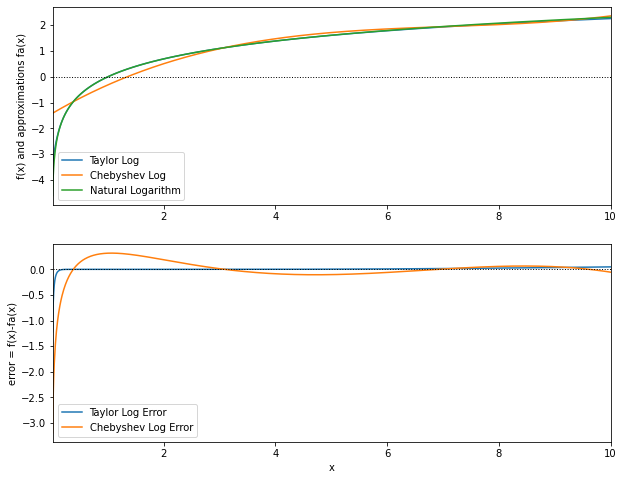

In [11]:
def taylor_ln(x, degree=5):
    result = 0
    for n in range(degree):
        t = (2 * n) + 1
        result += ((1 / t) * (((x - 1)/(x + 1))** t))
    return 2 * result

r = 10
chebyshev_ln =  ChebyshevPolynomial().fit(np.log, 4, 0.0001, r)
showplots(np.log, [taylor_ln, chebyshev_ln], 0.01 ,  r, 
          names=['Natural Logarithm', 'Taylor Log', 'Chebyshev Log'])

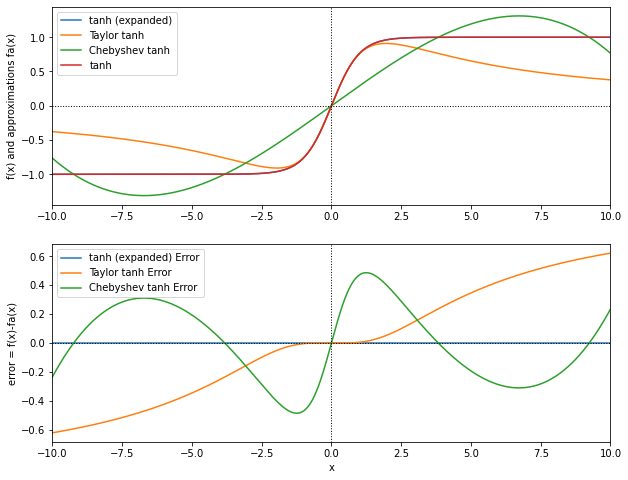

In [12]:
def tanh(x):
    return np.tanh(x)

def tanh_alt(x):
    a = np.exp(x)
    b = np.exp(-x)
    return (a - b) / (a + b)

def taylor_tanh(x, degree= 5):
    a = taylor_exp(x)
    b = taylor_exp(-x)
    return (a - b) / (a + b)

def chebyshev_tanh_exp(x):
    a = chebyshev_exp(x)
    b = chebyshev_exp(-x)
    return (a - b) / (a + b)

r = 10
chebyshev_tanh =  ChebyshevPolynomial().fit(tanh, 4, -r, r)
showplots(tanh, [tanh_alt, taylor_tanh, chebyshev_tanh], -r ,  r, 
          names=['tanh', 'tanh (expanded)', 'Taylor tanh', 'Chebyshev tanh'])


In [13]:
def square_activation(x):
    return x * x

r = 10
X = np.arange(-r, r, 10 ** -2)
Y = [square_activation(x) for x in X]

ys = [(Y, "Square")]
errors = [np.abs(Y - y[0]) for y in ys[1:]]
plot_vs(X, ys, errors, "Square Activation Function")

### ReLU approximation in CryptoDL

In [14]:
import sympy as sp

def integrate_sigmoid():
    x = sp.Symbol('x')
    return sp.integrate(1 / (1 + sp.exp(-x)), x)
integrate_sigmoid()

x + log(1 + exp(-x))

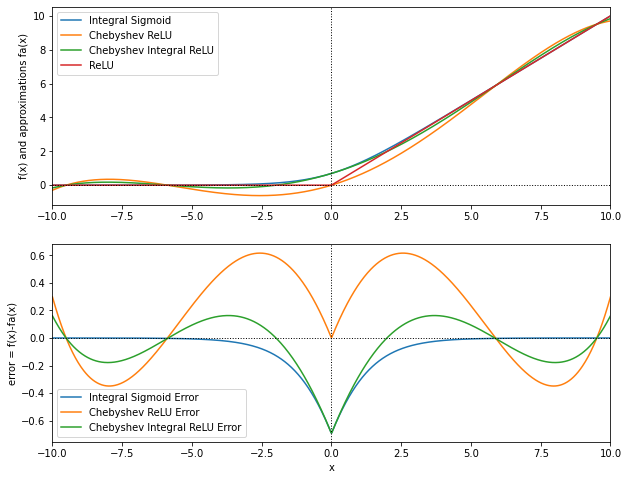

In [15]:
def integral_sigmoid(x):
    return x + np.log(1 + np.exp(-x))

def taylor_integral_sigmoid(x, degree=9):
    return x + taylor_ln(1 + taylor_exp(-x, degree), degree)

r = 10
chebyshev_relu = ChebyshevPolynomial().fit(relu, 5, -r, r)
chebyshev_integral_relu = ChebyshevPolynomial().fit(integral_sigmoid, 5, -r, r)

showplots(relu, [integral_sigmoid, chebyshev_relu, chebyshev_integral_relu], -r ,  r, 
          names=['ReLU', 'Integral Sigmoid', 'Chebyshev ReLU', 'Chebyshev Integral ReLU'])

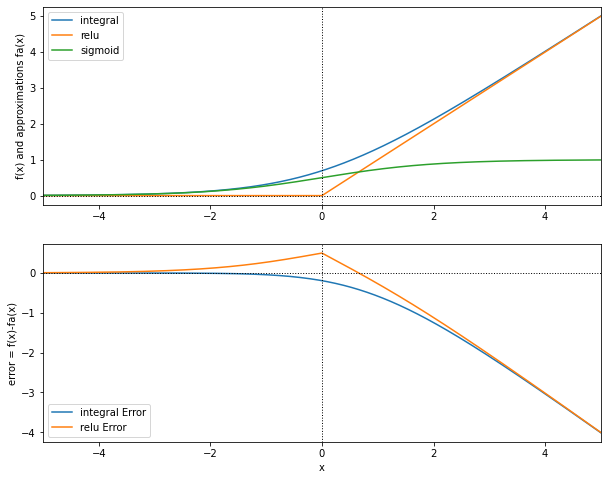

In [16]:
r = 5
showplots(sigmoid, [integral_sigmoid, relu], -r, r, ['sigmoid', 'integral', 'relu'])

In [17]:
import sympy as sp

def integrate_tanh():
    x = sp.Symbol('x')
    a = sp.exp(x)
    b = sp.exp(-x)
    return sp.integrate(((a - b)) / ((a + b)), x)

def sp_tanh():
    x = sp.Symbol('x')
    return sp.tanh(x)
sp.diff(sp.integrate(sp_tanh()))
integrate_tanh()

-x + log(exp(2*x) + 1)

In [18]:
def derivative_tanh():
    x = sp.Symbol('x')
    return sp.diff(-x + sp.log(sp.exp(2 * x) + 1), x)
derivative_tanh()

-1 + 2*exp(2*x)/(exp(2*x) + 1)

No handles with labels found to put in legend.


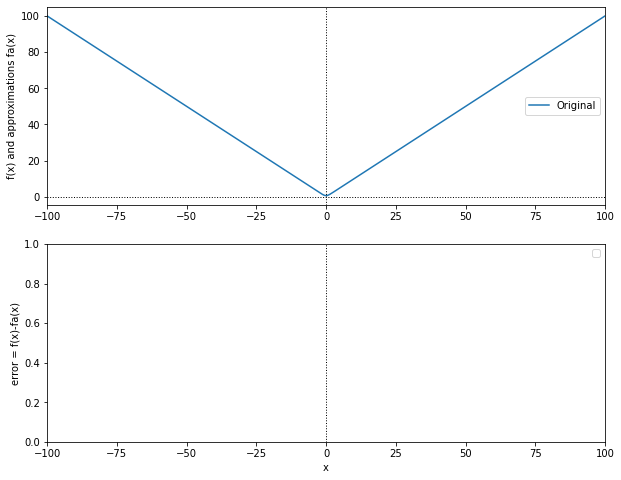

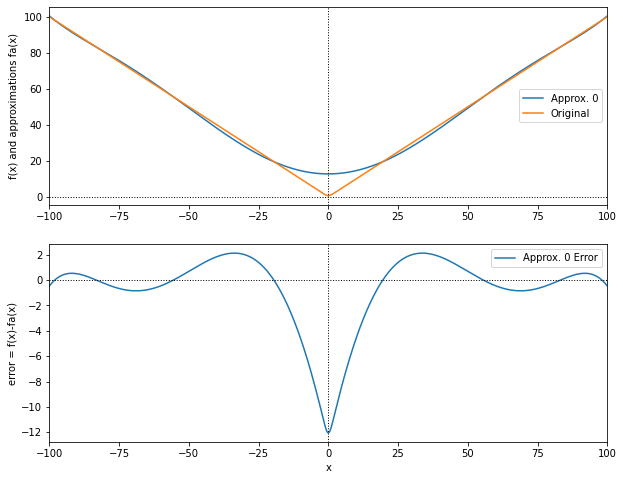

In [19]:
def integral_tanh(x):
    return -x + np.log(np.exp(2 * x) + 1)


def taylor_integral_sigmoid(x, degree=9):
    return x + taylor_ln(1 + taylor_exp(-x, degree), degree)

r = 100
showplots(integral_tanh, [],  -r , r)
chebyshev_tanh = ChebyshevPolynomial().fit(integral_tanh, 8, -r, r)
showplots(integral_tanh, [chebyshev_tanh], -r , r)

# Training neural networks with HIDDEN activations

In [20]:
def apple_discriminator(hidden=None, output=None):

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1], name='input_disc'))
    
    if not hidden is None:
        model.add(Activation(hidden)) ##Change with respect to previous
    else:
        model.add(layers.ReLU())
    
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    
    if not hidden is None:
        model.add(Activation(hidden)) ##Change with respect to previous
    else:
        model.add(layers.ReLU())
        
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    
    if not output is None:
        model.add(layers.Dense(1, name='output_disc'))
        model.add(Activation(output))
    else:
        model.add(layers.Dense(1, activation='sigmoid', name='output_disc'))

    model.compile(loss='binary_crossentropy', 
                  optimizer='sgd',
                  metrics=['accuracy', 'TruePositives', 'TrueNegatives', 'FalseNegatives', 'FalsePositives', 'AUC'])
    return model


In [21]:
log = pd.read_csv('models/statistics.csv').values.tolist() if os.path.exists('models/statistics.csv') else []
columns = ["Model Name", "Date", "Batch Size", "Epochs", "Loss", "Accuracy", "True Positives", "True Negatives", 
           "False Positives", "False Negatives", "AUC", "Validation Loss", "Validation Accuracy", "Validation True Positives", "Validation True Negatives", 
           "Validation False Positives", "Validation False Negatives", "Validation AUC",]

def train_model(model_name, X_train, Y_train, X_test, Y_test, batch_size, epochs, hidden=None, output=None):
    global log
    reset_seed()
    create_dir('models/%s' % (model_name))
    model =  apple_discriminator(hidden, output)
    history_callback = model.fit(x=X_train, y=Y_train, 
              batch_size=batch_size, epochs=epochs, verbose=1,
              validation_data=(X_test, Y_test))
    #print(history_callback.history)
    date = datetime.now()
    date_str = "%02d/%02d/%02d %02d:%02d" % (date.day, date.month, date.year, date.hour + 2, date.minute)
    t = [model_name, date_str, batch_size, epochs, ] + [v[0] for k, v in history_callback.history.items()]
    log.append(t)
    pd.DataFrame(log, 
                 columns=columns).to_csv ('models/statistics.csv', index = False, header=True)

    model.save('models/%s/apple_discriminator.h5' % (model_name))

In [22]:
X, Y = load_dataset()
train_test = X.shape[0] // 100 * 95
X_train, X_test = X[:train_test], X[train_test:]
Y_train, Y_test = Y[:train_test], Y[train_test:]
print(X_train.shape, X_test.shape)

(289468, 28, 28, 1) (289468,)
(274930, 28, 28, 1) (14538, 28, 28, 1)


## Base Model
This is the base benchmark model. It makes use of activations which are not

In [23]:
train_model('base', X_train, Y_train, X_test, Y_test, batch_size=32, epochs=10, hidden=None, output=None)

Directory  models/base  already exists
Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 93s 337us/sample - loss: 0.1924 - acc: 0.9384 - true_positives: 129186.0000 - true_negatives: 128807.0000 - false_negatives: 8240.0000 - false_positives: 8697.0000 - auc: 0.9762 - val_loss: 0.1454 - val_acc: 0.9555 - val_true_positives: 6931.0000 - val_true_negatives: 6960.0000 - val_false_negatives: 365.0000 - val_false_positives: 282.0000 - val_auc: 0.9830
Epoch 2/10
274930/274930 [==============================] - 89s 324us/sample - loss: 0.1373 - acc: 0.9579 - true_positives: 130600.0000 - true_negatives: 132751.0000 - false_negatives: 6826.0000 - false_positives: 4753.0000 - auc: 0.9847 - val_loss: 0.1253 - val_acc: 0.9626 - val_true_positives: 6946.0000 - val_true_negatives: 7048.0000 - val_false_negatives: 350.0000 - val_false_positives: 194.0000 - val_auc: 0.9867
Epoch 3/10
274930/274930 [==============================] - 89s 324u

## Using the square function (Most Efficient) (only hidden)
In the code below, we train the adversarial network making use of the square function as activation function. It provides the advantage that it is really efficient in the "encrypted" domain, however, the results do not seem to be promising or the neural network to be learning.

Although it seems to work, at times, the exploding gradient problem comes. Due to the fact that the $x^2$ squares numbers, all numbers inbetween 0 and 1 get reduced ($-1 <= x <= 1$), but numbers bigger than 1 ($x > 1$) or smaller than -1 ($x < -1$) , get highly increased.


In [24]:
train_model('square', X_train, Y_train, 
            X_test, Y_test, batch_size=32, epochs=10, 
            hidden=square_activation, output=None)

Directory  models/square  already exists
Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 96s 350us/sample - loss: 0.4221 - acc: 0.7572 - true_positives_2: 118913.0000 - true_negatives_2: 89277.0000 - false_negatives_2: 18513.0000 - false_positives_2: 48227.0000 - auc_2: 0.8767 - val_loss: 0.1503 - val_acc: 0.9545 - val_true_positives_2: 6962.0000 - val_true_negatives_2: 6914.0000 - val_false_negatives_2: 334.0000 - val_false_positives_2: 328.0000 - val_auc_2: 0.9826
Epoch 2/10
274930/274930 [==============================] - 94s 340us/sample - loss: 0.1500 - acc: 0.9536 - true_positives_2: 130291.0000 - true_negatives_2: 131890.0000 - false_negatives_2: 7135.0000 - false_positives_2: 5614.0000 - auc_2: 0.9831 - val_loss: 0.1225 - val_acc: 0.9626 - val_true_positives_2: 6951.0000 - val_true_negatives_2: 7043.0000 - val_false_negatives_2: 345.0000 - val_false_positives_2: 199.0000 - val_auc_2: 0.9879
Epoch 3/10
274930/274930 

## Using the Taylor polynomial approximation for sigmoid (only hidden layers)
In the code below, we train the adversarial network making use of the sigmoid taylor polynomial approximation.

In [25]:
train_model('taylor_sigmoid', X_train, Y_train,
            X_test, Y_test, batch_size=32, epochs=10, 
            hidden=taylor_sigmoid, output=None)

Directory  models/taylor_sigmoid  already exists
Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 131s 478us/sample - loss: 0.4308 - acc: 0.7694 - true_positives_4: 107453.0000 - true_negatives_4: 104070.0000 - false_negatives_4: 29973.0000 - false_positives_4: 33434.0000 - auc_4: 0.8748 - val_loss: 0.1974 - val_acc: 0.9331 - val_true_positives_4: 6797.0000 - val_true_negatives_4: 6769.0000 - val_false_negatives_4: 499.0000 - val_false_positives_4: 473.0000 - val_auc_4: 0.9742
Epoch 2/10
274930/274930 [==============================] - 129s 469us/sample - loss: 0.1981 - acc: 0.9330 - true_positives_4: 128375.0000 - true_negatives_4: 128141.0000 - false_negatives_4: 9051.0000 - false_positives_4: 9363.0000 - auc_4: 0.9738 - val_loss: 0.1753 - val_acc: 0.9415 - val_true_positives_4: 6838.0000 - val_true_negatives_4: 6849.0000 - val_false_negatives_4: 458.0000 - val_false_positives_4: 393.0000 - val_auc_4: 0.9780
Epoch 3/10
274


## Using the Chebyshev approximation for sigmoid (only hidden layers)


In [26]:
train_model('chebyshev_sigmoid', X_train, Y_train, 
            X_test, Y_test, batch_size=32, epochs=10, 
            hidden=chebyshev_sigmoid, output=None)

Directory  models/chebyshev_sigmoid  already exists
Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 141s 512us/sample - loss: 0.4569 - acc: 0.7627 - true_positives_6: 106934.0000 - true_negatives_6: 102759.0000 - false_negatives_6: 30492.0000 - false_positives_6: 34745.0000 - auc_6: 0.8634 - val_loss: 0.2186 - val_acc: 0.9267 - val_true_positives_6: 6818.0000 - val_true_negatives_6: 6654.0000 - val_false_negatives_6: 478.0000 - val_false_positives_6: 588.0000 - val_auc_6: 0.9711
Epoch 2/10
274930/274930 [==============================] - 135s 491us/sample - loss: 0.2186 - acc: 0.9269 - true_positives_6: 128020.0000 - true_negatives_6: 126822.0000 - false_negatives_6: 9406.0000 - false_positives_6: 10682.0000 - auc_6: 0.9708 - val_loss: 0.1994 - val_acc: 0.9362 - val_true_positives_6: 6772.0000 - val_true_negatives_6: 6838.0000 - val_false_negatives_6: 524.0000 - val_false_positives_6: 404.0000 - val_auc_6: 0.9747
Epoch 3/10


## Using the Taylor approximation for tanh (only hidden layers)


In [27]:
train_model('taylor_tanh', X_train, Y_train, 
            X_test, Y_test, batch_size=32, epochs=10, 
            hidden=taylor_tanh, output=None)

Directory  models/taylor_tanh  already exists
Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 154s 560us/sample - loss: 0.1910 - acc: 0.9367 - true_positives_8: 128689.0000 - true_negatives_8: 128836.0000 - false_negatives_8: 8737.0000 - false_positives_8: 8668.0000 - auc_8: 0.9757 - val_loss: 0.1642 - val_acc: 0.9475 - val_true_positives_8: 6836.0000 - val_true_negatives_8: 6939.0000 - val_false_negatives_8: 460.0000 - val_false_positives_8: 303.0000 - val_auc_8: 0.9803
Epoch 2/10
274930/274930 [==============================] - 152s 551us/sample - loss: 0.1596 - acc: 0.9488 - true_positives_8: 129674.0000 - true_negatives_8: 131183.0000 - false_negatives_8: 7752.0000 - false_positives_8: 6321.0000 - auc_8: 0.9808 - val_loss: 0.1425 - val_acc: 0.9547 - val_true_positives_8: 6871.0000 - val_true_negatives_8: 7009.0000 - val_false_negatives_8: 425.0000 - val_false_positives_8: 233.0000 - val_auc_8: 0.9837
Epoch 3/10
274930/2


## Using the Chebyshev approximation for tanh (only hidden layers)


In [28]:
train_model('chebyshev_tanh', X_train, Y_train, 
            X_test, Y_test, batch_size=32, epochs=10, 
            hidden=chebyshev_tanh, output=None)

Directory  models/chebyshev_tanh  already exists
Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 287s 1ms/sample - loss: nan - acc: 0.5001 - true_positives_10: 22.0000 - true_negatives_10: 137480.0000 - false_negatives_10: 137404.0000 - false_positives_10: 24.0000 - auc_10: 6.0011e-08 - val_loss: nan - val_acc: 0.4981 - val_true_positives_10: 0.0000e+00 - val_true_negatives_10: 7242.0000 - val_false_negatives_10: 7296.0000 - val_false_positives_10: 0.0000e+00 - val_auc_10: 0.0000e+00
Epoch 2/10
274930/274930 [==============================] - 285s 1ms/sample - loss: nan - acc: 0.5001 - true_positives_10: 0.0000e+00 - true_negatives_10: 137504.0000 - false_negatives_10: 137426.0000 - false_positives_10: 0.0000e+00 - auc_10: 0.0000e+00 - val_loss: nan - val_acc: 0.4981 - val_true_positives_10: 0.0000e+00 - val_true_negatives_10: 7242.0000 - val_false_negatives_10: 7296.0000 - val_false_positives_10: 0.0000e+00 - val_auc_10: 0

## Using the Taylor approximation for ReLU (only hidden layers)


In [29]:
train_model('taylor_relu', X_train, Y_train, 
            X_test, Y_test, batch_size=32, epochs=10, 
            hidden=taylor_relu, output=None)

Directory  models/taylor_relu  already exists
Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 135s 491us/sample - loss: 0.2246 - acc: 0.9288 - true_positives_12: 128350.0000 - true_negatives_12: 127016.0000 - false_negatives_12: 9076.0000 - false_positives_12: 10488.0000 - auc_12: 0.9709 - val_loss: 0.1761 - val_acc: 0.9421 - val_true_positives_12: 6892.0000 - val_true_negatives_12: 6804.0000 - val_false_negatives_12: 404.0000 - val_false_positives_12: 438.0000 - val_auc_12: 0.9784
Epoch 2/10
274930/274930 [==============================] - 133s 484us/sample - loss: 0.1678 - acc: 0.9461 - true_positives_12: 129547.0000 - true_negatives_12: 130570.0000 - false_negatives_12: 7879.0000 - false_positives_12: 6934.0000 - auc_12: 0.9795 - val_loss: 0.1533 - val_acc: 0.9514 - val_true_positives_12: 6826.0000 - val_true_negatives_12: 7005.0000 - val_false_negatives_12: 470.0000 - val_false_positives_12: 237.0000 - val_auc_12: 0.982


## Using the Chebyshev approximation for ReLU (only hidden layers)
In the code below, we train the adversarial network making use of the sigmoid taylor polynomial approximation.

In [30]:
train_model('chebyshev_relu', X_train, Y_train, 
            X_test, Y_test, batch_size=32, epochs=10, 
            hidden=chebyshev_relu, output=None)

Directory  models/chebyshev_relu  already exists
Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 157s 570us/sample - loss: 0.2275 - acc: 0.9274 - true_positives_14: 127865.0000 - true_negatives_14: 127100.0000 - false_negatives_14: 9561.0000 - false_positives_14: 10404.0000 - auc_14: 0.9700 - val_loss: 0.1814 - val_acc: 0.9378 - val_true_positives_14: 6866.0000 - val_true_negatives_14: 6768.0000 - val_false_negatives_14: 430.0000 - val_false_positives_14: 474.0000 - val_auc_14: 0.9774
Epoch 2/10
274930/274930 [==============================] - 155s 563us/sample - loss: 0.1747 - acc: 0.9417 - true_positives_14: 129071.0000 - true_negatives_14: 129825.0000 - false_negatives_14: 8355.0000 - false_positives_14: 7679.0000 - auc_14: 0.9785 - val_loss: 0.1633 - val_acc: 0.9461 - val_true_positives_14: 6829.0000 - val_true_negatives_14: 6926.0000 - val_false_negatives_14: 467.0000 - val_false_positives_14: 316.0000 - val_auc_14: 0.


## Using the Chebyshev approximation for ReLU with Sigmoid Derivative(only hidden layers)
In the code below, we train the adversarial network making use of the sigmoid taylor polynomial approximation.

In [31]:
train_model('chebyshev_integral_relu', X_train, Y_train, 
            X_test, Y_test, batch_size=32, epochs=10, 
            hidden=chebyshev_integral_relu, output=None)

Directory  models/chebyshev_integral_relu  already exists
Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 152s 553us/sample - loss: 0.2529 - acc: 0.9002 - true_positives_16: 124089.0000 - true_negatives_16: 123416.0000 - false_negatives_16: 13337.0000 - false_positives_16: 14088.0000 - auc_16: 0.9619 - val_loss: 0.1714 - val_acc: 0.9446 - val_true_positives_16: 6858.0000 - val_true_negatives_16: 6874.0000 - val_false_negatives_16: 438.0000 - val_false_positives_16: 368.0000 - val_auc_16: 0.9784
Epoch 2/10
274930/274930 [==============================] - 151s 551us/sample - loss: 0.1728 - acc: 0.9443 - true_positives_16: 129374.0000 - true_negatives_16: 130253.0000 - false_negatives_16: 8052.0000 - false_positives_16: 7251.0000 - auc_16: 0.9784 - val_loss: 0.1608 - val_acc: 0.9490 - val_true_positives_16: 6862.0000 - val_true_negatives_16: 6935.0000 - val_false_negatives_16: 434.0000 - val_false_positives_16: 307.0000 - val_

In [44]:
pd.read_csv('models/statistics.csv')

,Model Name,Date,Batch Size,Epochs,Loss,Accuracy,True Positives,True Negatives,False Positives,False Negatives,AUC,Validation Loss,Validation Accuracy,Validation True Positives,Validation True Negatives,Validation False Positives,Validation False Negatives,Validation AUC
0,base,20/04/2020 09:37,32,10,0.192357,0.938395,129186.0,128807.0,8240.0,8697.0,9.761881e-01,0.145449,0.955496,6931.0,6960.0,365.0,282.0,0.983027
1,square,20/04/2020 09:52,32,10,0.422064,0.757247,118913.0,89277.0,18513.0,48227.0,8.766960e-01,0.150291,0.954464,6962.0,6914.0,334.0,328.0,0.982594
2,taylor_sigmoid,20/04/2020 10:14,32,10,0.430751,0.769370,107453.0,104070.0,29973.0,33434.0,8.747632e-01,0.197381,0.933141,6797.0,6769.0,499.0,473.0,0.974224
3,chebyshev_sigmoid,20/04/2020 10:36,32,10,0.456864,0.762714,106934.0,102759.0,30492.0,34745.0,8.633711e-01,0.218603,0.926675,6818.0,6654.0,478.0,588.0,0.971098
4,taylor_tanh,20/04/2020 11:02,32,10,0.191026,0.936693,128689.0,128836.0,8737.0,8668.0,9.756894e-01,0.164203,0.947517,6836.0,6939.0,460.0,303.0,0.980280
5,chebyshev_tanh,20/04/2020 11:49,32,10,NaN,0.500135,22.0,137480.0,137404.0,24.0,6.001072e-08,NaN,0.498143,0.0,7242.0,7296.0,0.0,0.000000
6,taylor_relu,20/04/2020 12:12,32,10,0.224601,0.928840,128350.0,127016.0,9076.0,10488.0,9.709114e-01,0.176057,0.942083,6892.0,6804.0,404.0,438.0,0.978384
7,chebyshev_relu,20/04/2020 12:37,32,10,0.227496,0.927382,127865.0,127100.0,9561.0,10404.0,9.700469e-01,0.181416,0.937818,6866.0,6768.0,430.0,474.0,0.977378
8,chebyshev_integral_relu,20/04/2020 13:03,32,10,0.252871,0.900247,124089.0,123416.0,13337.0,14088.0,9.619038e-01,0.171355,0.944559,6858.0,6874.0,438.0,368.0,0.978434


In [43]:
data = pd.read_csv('models/statistics.csv')
data['Model Name'],data['Loss']

(0                        base
 1                      square
 2              taylor_sigmoid
 3           chebyshev_sigmoid
 4                 taylor_tanh
 5              chebyshev_tanh
 6                 taylor_relu
 7              chebyshev_relu
 8     chebyshev_integral_relu
 9                        base
 10                     square
 11             taylor_sigmoid
 12          chebyshev_sigmoid
 13                taylor_tanh
 14             chebyshev_tanh
 15                taylor_relu
 16             chebyshev_relu
 17    chebyshev_integral_relu
 Name: Model Name, dtype: object,
 0     0.193109
 1     0.400919
 2     0.422356
 3     0.434984
 4     0.191805
 5          NaN
 6     0.225185
 7     0.230252
 8     0.250058
 9     0.192357
 10    0.422064
 11    0.430751
 12    0.456864
 13    0.191026
 14         NaN
 15    0.224601
 16    0.227496
 17    0.252871
 Name: Loss, dtype: float64)


# Output layers
In the code below, we train the adversarial network making use of the sigmoid taylor polynomial approximation.


## Using the Taylor approximation for sigmoid (only output layers)



## Using the Chebyshev approximation for sigmoid (only output layers)



## Using the Taylor approximation for tanh (only output layers)



## Using the Chebyshev approximation for tanh (only output layers)


In [ ]:
gen_model_act, disc_mod_act, gan_mod_act = test_activation_function(relu_regression_2)
animation4 = full_training(gen_model_act, disc_mod_act, gan_mod_act, 5000, 50, 32, 'relu_regression_2')

In [ ]:
display.Image(filename=animation4)

## Trying the ReLU regression as activation function d=15 (only hidden)

In [ ]:
gen_model_act, disc_mod_act, gan_mod_act = test_activation_function(relu_regression_15)
animation5 = full_training(gen_model_act, disc_mod_act, gan_mod_act, 5000, 50, 32, 'relu_regression_15')

In [ ]:
display.Image(filename=animation5)

# Private inference

In [ ]:
def private_pred(model, x):
    custom_functions = {'relu_regression_2': relu_regression_2,
                        'relu_regression_15': relu_regression_15,
                        'taylor_sigmoid': taylor_sigmoid,
                        'square_activation': square_activation}
    # Reset the graph and backend learning phase.
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)
    
    # Load generator as H5
    generator = tf.keras.models.load_model('models/%s/generator.h5' % (model), 
                                           custom_objects=custom_functions)
    print("Loaded %s model    " % (model))
        # Save model as PB
    save_model(tf.compat.v1.keras.backend.get_session(), 
               ["output_gen/conv2d_transpose"], "./models/%s/"%(model), 
               model)

    
    # Reset again the default graph
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)

    
    tf.import_graph_def(load_pb_file("./models/%s/%s.pb"%(model, model)))  
    
    x_input = tf.compat.v1.get_default_graph().get_tensor_by_name('import/input_gen_input:0')
    y_output = tf.compat.v1.get_default_graph().get_tensor_by_name('import/output_gen/conv2d_transpose:0')
    print_nodes()
    config = get_config_for_ngraph_server(x_input.name)
    with tf.compat.v1.Session(config=config) as sess:
        print("Executing new comp")
        sess.run(tf.compat.v1.global_variables_initializer())
        start_time = time.time()
        y_hat = y_output.eval(feed_dict={x_input: x })
        y_pred = np.tanh(y_hat)
        elasped_time = time.time() - start_time
        print("Total time(s)", np.round(elasped_time, 3))
        return y_pred

def private_pred2(model, x):
    custom_functions = {'relu_regression_2': relu_regression_2,
                        'relu_regression_15': relu_regression_15,
                        'taylor_sigmoid': taylor_sigmoid,
                        'square_activation': square_activation}
    # Reset the graph and backend learning phase.
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)
    
    # Load generator as H5
    discriminator = tf.keras.models.load_model('models/%s/discriminator.h5' % (model), 
                                           custom_objects=custom_functions)
    #print_nodes()
    print("Loaded %s model    " % (model))
        # Save model as PB
    save_model(tf.compat.v1.keras.backend.get_session(), 
               ["output_disc/BiasAdd"], "./models/%s/"%(model), 
               model)

    
    # Reset again the default graph
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)

    
    tf.import_graph_def(load_pb_file("./models/%s/%s.pb"%(model, model)))  
    
    x_input = tf.compat.v1.get_default_graph().get_tensor_by_name('import/input_disc_input:0')
    y_output = tf.compat.v1.get_default_graph().get_tensor_by_name('import/output_disc/BiasAdd:0')
    print_nodes()
    config = get_config_for_ngraph_server(x_input.name)
    with tf.compat.v1.Session(config=config) as sess:
        print("Executing new comp")
        sess.run(tf.compat.v1.global_variables_initializer())
        start_time = time.time()
        y_hat = y_output.eval(feed_dict={x_input: x })
        y_pred = np.tanh(y_hat)
        elasped_time = time.time() - start_time
        print("Total time(s)", np.round(elasped_time, 3))
        return y_pred
y_pred = private_pred2('square2', np.random.normal(0, 1, [1, 28, 28, 1]))    

In [ ]:
%%time
y_pred = private_pred2('square2', np.random.normal(0, 1, [1, 28, 28, 1]))    

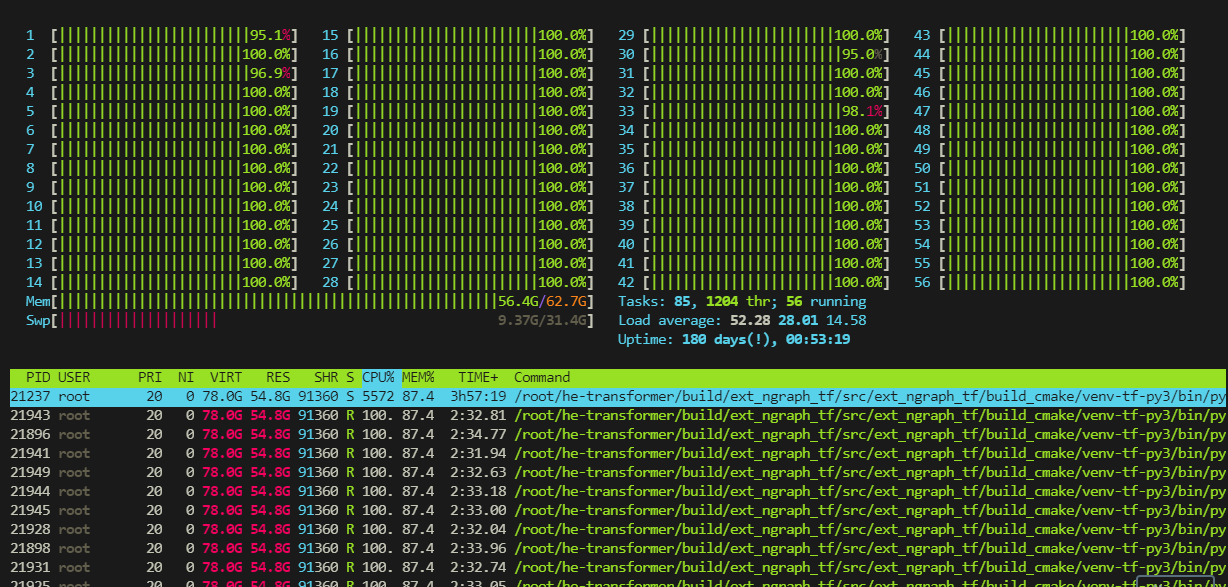

## Trying to simplify the model

In [ ]:
def generator_model_simplified(activation):

    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, input_shape=(100,), name='input_gen'))
    model.add(Activation(activation)) ##Change with respect to previous

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.AveragePooling2D(pool_size=(3,3), strides=(1,1), padding='same'))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(Activation(activation)) ##Change with respect to previous 

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.AveragePooling2D(pool_size=(3,3), strides=(1,1), padding='same'))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(Activation(activation)) ##Change with respect to previous
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                                     activation='tanh', name='output_gen'))
    #model.add(Activation(activation)) ##Change with respect to previous
    assert model.output_shape == (None, 28, 28, 1)
    model.compile(loss='binary_crossentropy', optimizer='sgd')
    
    return model


def discriminator_model_simplified(activation):

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1], name='input_disc'))
    model.add(Activation(activation)) ##Change with respect to previous
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(Activation(activation)) ##Change with respect to previous
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid', name='output_disc'))
    #model.add(Activation(activation)) ##Change with respect to previous
    model.compile(loss='binary_crossentropy', 
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model


def gan_model_simplified(generator, discriminator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    #gan.compile(loss='binary_crossentropy', optimizer='adam')
    gan.compile(loss='binary_crossentropy', 
                optimizer='sgd')
    return gan
            
              
def test_activation_function_simplified(function):
    generator_act = lambda: generator_model_simplified(function)
    dicriminator_act = lambda: discriminator_model_simplified(function)
    gan_act = gan_model_simplified
    return generator_act, dicriminator_act, gan_act

In [ ]:
gen_model_act, disc_mod_act, gan_mod_act = test_activation_function_simplified(square_activation)
animation6 = full_training(gen_model_act, disc_mod_act, gan_mod_act, 5000, 50, 32, 'square_simple')

# Looking inside the activations

In this section, we try to take a look at the inner part of the activation functions

In [ ]:
generator, discriminator = None, None

def my_event_handler(btn_object):
    global generator, discriminator
    # Clear output and select a new model.
    display.clear_output(wait=True)
    display_models()
    model = btn_object.description
    print("Loading %s model..." % (model), end='\r')
    
    custom_functions = {'relu_regression_2': relu_regression_2,
                        'relu_regression_15': relu_regression_15,
                        'taylor_sigmoid': taylor_sigmoid,
                        'square_activation': square_activation}
    # Reset the graph and backend learning phase.
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)
    
    # Load generator as H5
    generator = tf.keras.models.load_model('models/%s/generator.h5' % (model), 
                                           custom_objects=custom_functions)
    discriminator = tf.keras.models.load_model('models/%s/discriminator.h5' % (model), 
                                           custom_objects=custom_functions)
    print("Loaded %s model    " % (model))


def display_models():
    print("Click on a model to execute it on a private input:")
    dirs = os.listdir( 'models/' )
    for d in dirs:
        btn = widgets.Button(description=d)
        btn.on_click(my_event_handler)
        display.display(btn)
        
display_models()   

In [ ]:
def print_intermediate_steps(model, test_activations, layer_interval):
    layer_outputs = [layer.output for layer in model.layers[layer_interval[0]:layer_interval[1]]]
    activation_model = Model(inputs=model.input,outputs=layer_outputs)
    activations = activation_model.predict(test_activations)
    #print("·$")
    layer_names = []
    for layer in model.layers[layer_interval[0]:layer_interval[1]]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    images_per_row = 16
    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        #print("Layer: %s" %(layer_name))
        try:
            if not ('activation' in layer_name or 
                    'conv' in layer_name or
                    're_lu' in layer_name or
                    'input_disc' in layer_name or 
                    'output_gen' in layer_name):
                continue
            n_features = layer_activation.shape[-1] # Number of features in the feature map
            size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
            n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
            display_grid = np.zeros((size * n_cols, images_per_row * size))

            for col in range(n_cols): # Tiles each filter into a big horizontal grid
                for row in range(images_per_row):
                    channel_image = layer_activation[0,
                                                     :, :,
                                                     col * images_per_row + row]
                    channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size : (col + 1) * size, # Displays the grid
                                 row * size : (row + 1) * size] = channel_image
            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1],
                                scale * display_grid.shape[0]))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
        except (RuntimeError):
            print("ERROR ON LAYER: %s" % (layer_name))
            print(RuntimeError)


In [ ]:
real_dataset = preprocess_real_samples(np.load('apple.npy'))


In [ ]:
noise = np.random.normal(0, 1, (1, 100))

In [ ]:
generator.summary()
print_intermediate_steps(generator, noise, (4, 10))

In [ ]:
discriminator.summary()
print_intermediate_steps(discriminator, real_dataset[3:4], (0, 8))

In [ ]:
def my_event_handler(btn_object):

    # Clear output and select a new model.
    display.clear_output(wait=True)
    display_models()
    model = btn_object.description
    print("Loading %s model..." % (model), end='\r')
    
    custom_functions = {'relu_regression_2': relu_regression_2,
                        'relu_regression_15': relu_regression_15,
                        'taylor_sigmoid': taylor_sigmoid,
                        'square_activation': square_activation}
    # Reset the graph and backend learning phase.
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)
    
    # Load generator as H5
    generator = tf.keras.models.load_model('models/%s/generator.h5' % (model), 
                                           custom_objects=custom_functions)
    discriminator = tf.keras.models.load_model('models/%s/discriminator.h5' % (model), 
                                           custom_objects=custom_functions)
    print("Loaded %s model    " % (model))
    print_intermediate_steps(generator, noise, (4, 10))
    
    print_intermediate_steps(discriminator, real_dataset[3:10], (0, 8))
    


def display_models():
    print("Click on a model to execute it on a private input:")
    dirs = os.listdir( 'models/' )
    for d in dirs:
        btn = widgets.Button(description=d)
        btn.on_click(my_event_handler)
        display.display(btn)
        
display_models()   